In [1]:
# Setup and imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set project root
project_root = Path("/home/Plutonium/Documents/BioinfoMidterm")
os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("khv_jpt_chb")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)

# Classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

print("All imports successful!")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
All imports successful!


## Step 1: Load Statistical Results and ML Data

In [2]:
# Load statistical SNP scores from 03b
stats_path = str(PATHS.OUTPUT_DIR / "statistics_snp_scores.csv")
print(f"Loading statistical results from: {stats_path}")

stats_df = pd.read_csv(stats_path)
print(f"Statistical results shape: {stats_df.shape}")
print(f"\nColumns: {list(stats_df.columns)}")

# Load ML data (genotype matrix with population labels)
ml_data_path = str(PATHS.ML_DATA)
print(f"\nLoading ML data from: {ml_data_path}")

df = pd.read_csv(ml_data_path)
print(f"ML data shape: {df.shape}")
print(f"\nPopulation distribution:")
print(df['pop'].value_counts())

Loading statistical results from: 1000genomes/output/statistics_snp_scores.csv
Statistical results shape: (2637, 21)

Columns: ['snp_id', 'chi2', 'chi2_pvalue', 'g_stat', 'g_pvalue', 'fisher_or', 'fisher_pvalue', 'mutual_information', 'information_gain', 'kl_divergence', 'lr_coef', 'lr_se', 'lr_zscore', 'lr_pvalue', 'lr_pseudo_r2', 'chi2_qvalue', 'chi2_significant_bonf', 'chi2_significant_fdr', 'lr_qvalue', 'lr_significant_bonf', 'lr_significant_fdr']

Loading ML data from: 1000genomes/vcf_khv_jpt_chb/vcf_numeric_transposed_with_population.csv


FileNotFoundError: [Errno 2] No such file or directory: '1000genomes/vcf_khv_jpt_chb/vcf_numeric_transposed_with_population.csv'

In [ ]:
# Prepare features and labels
sample_ids = df['sample']
populations = df['pop']
snp_columns = [c for c in df.columns if c not in ['sample', 'pop']]
X_all = df[snp_columns]
y = populations

print(f"Total samples: {len(df)}")
print(f"Total SNPs in ML data: {len(snp_columns)}")
print(f"\nFirst 5 SNP columns: {snp_columns[:5]}")

Total samples: 306
Total SNPs in ML data: 2637

First 5 SNP columns: ['11:365918', '11:459069', '11:997733', '11:1868169', '11:2042945']


## Step 2: Identify Consensus SNPs (Significant in All 4 Tests)

In [ ]:
# Define significance criteria for each test
# Using FDR-corrected significance for chi2, and top 500 for information-theoretic measures

# Check if significance columns exist
if 'chi2_significant_fdr' in stats_df.columns:
    sig_chi2 = set(stats_df[stats_df['chi2_significant_fdr']]['snp_id'])
else:
    # Fallback: use top 500 by chi2
    sig_chi2 = set(stats_df.nlargest(500, 'chi2')['snp_id'])

sig_mi = set(stats_df.nlargest(500, 'mutual_information')['snp_id'])
sig_ig = set(stats_df.nlargest(500, 'information_gain')['snp_id'])
sig_kl = set(stats_df.nlargest(500, 'kl_divergence')['snp_id'])

print("SNPs Selected by Each Test:")
print("="*60)
print(f"χ² test (FDR significant or top 500): {len(sig_chi2)}")
print(f"Mutual Information (top 500): {len(sig_mi)}")
print(f"Information Gain (top 500): {len(sig_ig)}")
print(f"KL Divergence (top 500): {len(sig_kl)}")

# Count SNPs appearing in multiple tests
all_sig_snps = list(sig_chi2) + list(sig_mi) + list(sig_ig) + list(sig_kl)
snp_counts = Counter(all_sig_snps)

# Get consensus SNPs
snps_in_4 = [s for s, c in snp_counts.items() if c == 4]
snps_in_3 = [s for s, c in snp_counts.items() if c >= 3]
snps_in_2 = [s for s, c in snp_counts.items() if c >= 2]

print(f"\nConsensus SNPs:")
print(f"  Significant in ALL 4 tests: {len(snps_in_4)}")
print(f"  Significant in ≥3 tests: {len(snps_in_3)}")
print(f"  Significant in ≥2 tests: {len(snps_in_2)}")

SNPs Selected by Each Test:
χ² test (FDR significant or top 500): 2637
Mutual Information (top 500): 500
Information Gain (top 500): 500
KL Divergence (top 500): 500

Consensus SNPs:
  Significant in ALL 4 tests: 164
  Significant in ≥3 tests: 500
  Significant in ≥2 tests: 836


In [ ]:
# Select consensus SNPs for training
# Use SNPs significant in all 4 tests if enough, otherwise use ≥3

if len(snps_in_4) >= 50:
    consensus_snps = snps_in_4
    consensus_level = "all 4 tests"
elif len(snps_in_3) >= 50:
    consensus_snps = snps_in_3
    consensus_level = "≥3 tests"
else:
    consensus_snps = snps_in_2
    consensus_level = "≥2 tests"

print(f"Using {len(consensus_snps)} SNPs significant in {consensus_level}")

# Filter to SNPs that exist in ML data
available_consensus = [s for s in consensus_snps if s in snp_columns]
print(f"Available in ML data: {len(available_consensus)} SNPs")

# If still not enough, use top SNPs by composite score
if len(available_consensus) < 25:
    print("\nNot enough consensus SNPs. Using top SNPs by composite score...")
    # Create composite score (rank average)
    stats_df['rank_chi2'] = stats_df['chi2'].rank(ascending=False)
    stats_df['rank_mi'] = stats_df['mutual_information'].rank(ascending=False)
    stats_df['rank_ig'] = stats_df['information_gain'].rank(ascending=False)
    stats_df['rank_kl'] = stats_df['kl_divergence'].rank(ascending=False)
    stats_df['composite_rank'] = (stats_df['rank_chi2'] + stats_df['rank_mi'] + 
                                   stats_df['rank_ig'] + stats_df['rank_kl']) / 4
    
    top_composite = stats_df.nsmallest(500, 'composite_rank')['snp_id'].tolist()
    available_consensus = [s for s in top_composite if s in snp_columns]
    print(f"Using top {len(available_consensus)} SNPs by composite rank")

Using 164 SNPs significant in all 4 tests
Available in ML data: 164 SNPs


In [ ]:
# Create training data with consensus SNPs
X_consensus = X_all[available_consensus]

print(f"\nConsensus Training Data:")
print(f"  Samples: {X_consensus.shape[0]}")
print(f"  Features (consensus SNPs): {X_consensus.shape[1]}")
print(f"\nFirst 10 consensus SNPs:")
for i, snp in enumerate(available_consensus[:10], 1):
    print(f"  {i}. {snp}")


Consensus Training Data:
  Samples: 306
  Features (consensus SNPs): 164

First 10 consensus SNPs:
  1. 16:89684324
  2. 4:15787630
  3. 12:69529089
  4. 19:1717296
  5. 11:4795309
  6. 4:5532600
  7. 6:158490397
  8. 4:186416538
  9. 8:134733673
  10. 6:133653349


## Step 3: Train Random Forest on Consensus SNPs

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_consensus, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Encode labels for XGBoost compatibility
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nClass encoding: {dict(zip(le.classes_, range(len(le.classes_))))}")

Training set: 244 samples
Test set: 62 samples

Class encoding: {'CHB': 0, 'JPT': 1, 'KHV': 2}


In [ ]:
# Train Random Forest on consensus SNPs
print("Training Random Forest on consensus SNPs...")

rf_consensus = RandomForestClassifier(
    n_estimators=ML.RF_N_ESTIMATORS,
    max_depth=ML.RF_MAX_DEPTH,
    random_state=42,
    n_jobs=-1
)

rf_consensus.fit(X_train, y_train)

# Evaluate
y_pred_consensus = rf_consensus.predict(X_test)
accuracy_consensus = accuracy_score(y_test, y_pred_consensus)

print(f"\nRandom Forest on Consensus SNPs ({len(available_consensus)} features):")
print(f"  Accuracy: {accuracy_consensus:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_consensus))

Training Random Forest on consensus SNPs...

Random Forest on Consensus SNPs (164 features):
  Accuracy: 0.9516

Classification Report:
              precision    recall  f1-score   support

         CHB       1.00      0.86      0.92        21
         JPT       0.88      1.00      0.93        21
         KHV       1.00      1.00      1.00        20

    accuracy                           0.95        62
   macro avg       0.96      0.95      0.95        62
weighted avg       0.96      0.95      0.95        62



In [ ]:
# Get feature importances and select top 25
feature_importance = pd.DataFrame({
    'snp': available_consensus,
    'importance': rf_consensus.feature_importances_
}).sort_values('importance', ascending=False)

# Add statistical scores
feature_importance = feature_importance.merge(
    stats_df[['snp_id', 'chi2', 'mutual_information', 'information_gain', 'kl_divergence']],
    left_on='snp', right_on='snp_id', how='left'
).drop('snp_id', axis=1)

print("Top 25 SNPs by Random Forest Importance:")
print("="*80)
display(feature_importance.head(25))

# Get top 25 SNP IDs
TOP_N = ML.TOP_N_FEATURES  # 25
top_25_snps = feature_importance.head(TOP_N)['snp'].tolist()

print(f"\nSelected {TOP_N} top SNPs for final model training")

Top 25 SNPs by Random Forest Importance:


,snp,importance,chi2,mutual_information,information_gain,kl_divergence
0,3:100365528,0.033631,92.546354,0.200202,0.288831,0.551638
1,11:61548559,0.025961,109.785504,0.194369,0.280415,0.644537
2,17:40956277,0.025839,104.742995,0.170393,0.245825,0.672299
3,18:18518431,0.016388,70.321824,0.131891,0.190278,0.339323
4,4:101002868,0.016134,78.693340,0.139602,0.201404,3.986245
5,1:22315762,0.015459,78.803007,0.128041,0.184725,0.756917
6,1:569204,0.014528,97.681099,0.152949,0.220658,0.497955
7,5:84489662,0.014002,37.931336,0.065255,0.094143,0.321306
8,8:139071833,0.013735,47.873589,0.081927,0.118196,0.604704
9,16:89684324,0.013577,47.858221,0.083747,0.120821,0.299061



Selected 25 top SNPs for final model training


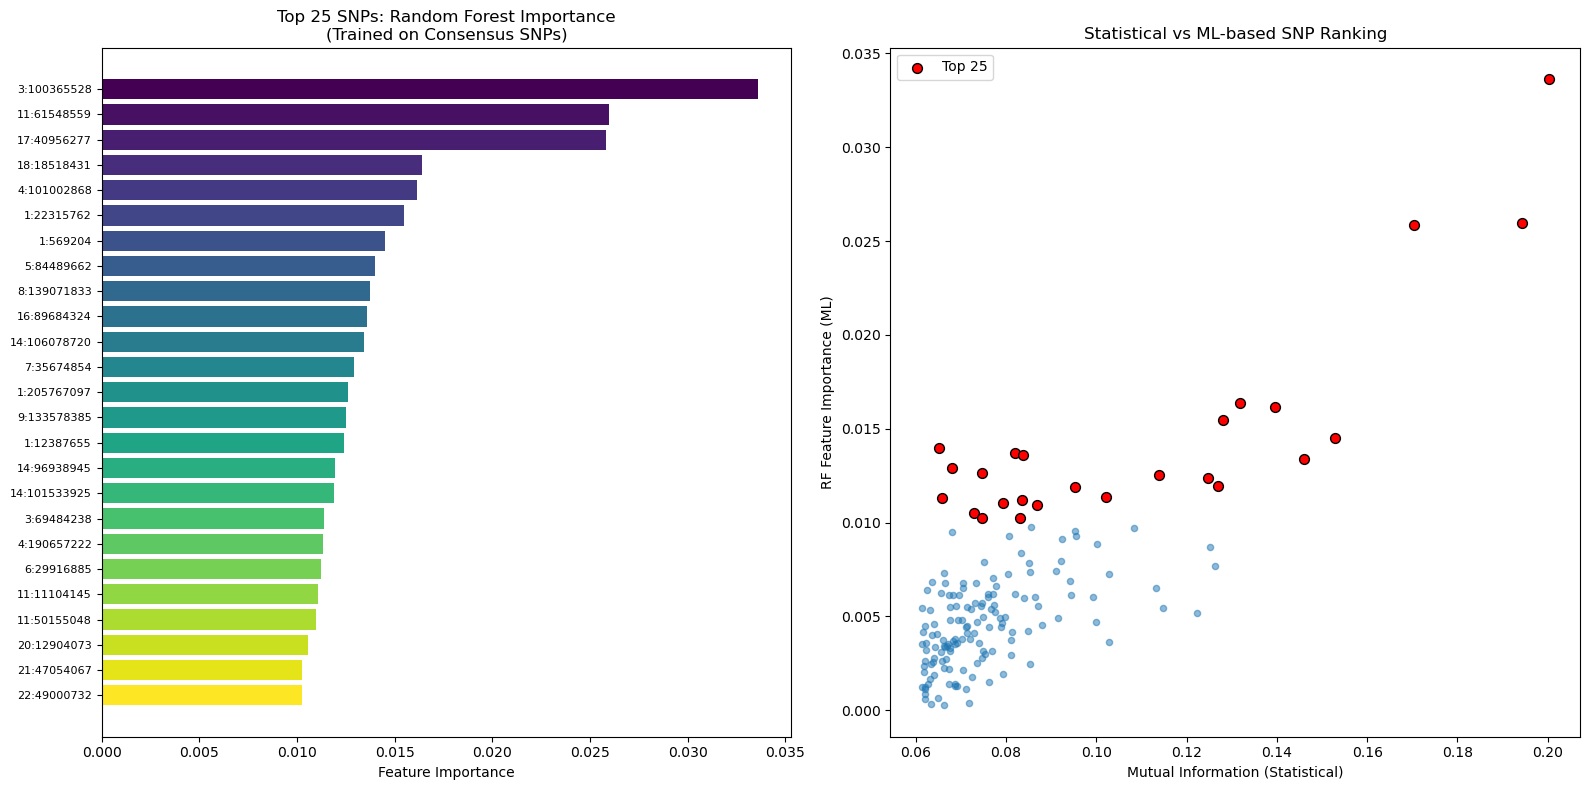

In [ ]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Top 25 RF importance
ax = axes[0]
top_25_df = feature_importance.head(25)
colors = plt.cm.viridis(np.linspace(0, 1, 25))
bars = ax.barh(range(25), top_25_df['importance'].values, color=colors)
ax.set_yticks(range(25))
ax.set_yticklabels(top_25_df['snp'].values, fontsize=8)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 25 SNPs: Random Forest Importance\n(Trained on Consensus SNPs)')

# Plot 2: Importance vs MI scatter
ax = axes[1]
ax.scatter(feature_importance['mutual_information'], 
           feature_importance['importance'], alpha=0.5, s=20)
# Highlight top 25
top_25_mask = feature_importance['snp'].isin(top_25_snps)
ax.scatter(feature_importance.loc[top_25_mask, 'mutual_information'],
           feature_importance.loc[top_25_mask, 'importance'],
           color='red', s=50, label='Top 25', edgecolors='black')
ax.set_xlabel('Mutual Information (Statistical)')
ax.set_ylabel('RF Feature Importance (ML)')
ax.set_title('Statistical vs ML-based SNP Ranking')
ax.legend()

plt.tight_layout()
plt.show()

## Step 4: Train Multiple Classifiers on Top 25 SNPs

In [ ]:
# Create training data with top 25 SNPs
X_top25 = X_all[top_25_snps]

# Train/test split
X_train_25, X_test_25, y_train_25, y_test_25 = train_test_split(
    X_top25, y, test_size=0.2, random_state=42, stratify=y
)

# Encode labels
y_train_25_enc = le.fit_transform(y_train_25)
y_test_25_enc = le.transform(y_test_25)

# Scale for algorithms that need it
scaler = StandardScaler()
X_train_25_scaled = scaler.fit_transform(X_train_25)
X_test_25_scaled = scaler.transform(X_test_25)

print(f"Top 25 Training Data:")
print(f"  Training: {X_train_25.shape}")
print(f"  Test: {X_test_25.shape}")

Top 25 Training Data:
  Training: (244, 25)
  Test: (62, 25)


In [ ]:
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(
        n_estimators=ML.RF_N_ESTIMATORS, max_depth=ML.RF_MAX_DEPTH, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=ML.XGB_N_ESTIMATORS, max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE, random_state=42, n_jobs=-1, verbosity=0
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, multi_class='multinomial', n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf', random_state=42, probability=True
    ),
    'SVM (Linear)': SVC(
        kernel='linear', random_state=42, probability=True
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5, n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, max_depth=5, random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100, random_state=42, algorithm='SAMME'
    ),
    'MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True
    )
}

# Try to add TabPFN
try:
    from tabpfn import TabPFNClassifier
    TABPFN_AVAILABLE = True
    print("TabPFN is available and will be included in evaluation")
except ImportError:
    TABPFN_AVAILABLE = False
    print("TabPFN not installed. Install with: pip install tabpfn")

print(f"Training {len(classifiers)} classifiers on top {TOP_N} statistical SNPs...")

Training 10 classifiers on top 25 statistical SNPs...


In [ ]:
# Train and evaluate all classifiers
results = []

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    
    # Select appropriate data (scaled vs unscaled, encoded vs string labels)
    if 'SVM' in name or 'Logistic' in name or 'KNN' in name or 'MLP' in name:
        X_tr, X_te = X_train_25_scaled, X_test_25_scaled
    else:
        X_tr, X_te = X_train_25.values, X_test_25.values
    
    # Use encoded labels for XGBoost and MLP
    if 'XGBoost' in name or 'MLP' in name:
        y_tr, y_te = y_train_25_enc, y_test_25_enc
    else:
        y_tr, y_te = y_train_25, y_test_25
    
    try:
        # Train
        clf.fit(X_tr, y_tr)
        
        # Predict
        y_pred = clf.predict(X_te)
        
        # Metrics
        acc = accuracy_score(y_te, y_pred)
        
        # Convert back for consistent reporting
        if 'XGBoost' in name or 'MLP' in name:
            y_te_str = le.inverse_transform(y_te)
            y_pred_str = le.inverse_transform(y_pred)
        else:
            y_te_str = y_te
            y_pred_str = y_pred
        
        prec = precision_score(y_te_str, y_pred_str, average='weighted')
        rec = recall_score(y_te_str, y_pred_str, average='weighted')
        f1 = f1_score(y_te_str, y_pred_str, average='weighted')
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_tr, y_tr, cv=cv, scoring='accuracy')
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std()
        })
        
        print(f"  Accuracy: {acc:.4f} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
    except Exception as e:
        print(f"  Error: {e}")
        results.append({
            'Model': name,
            'Accuracy': np.nan,
            'Precision': np.nan,
            'Recall': np.nan,
            'F1-Score': np.nan,
            'CV Mean': np.nan,
            'CV Std': np.nan
        })

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
display(results_df)


Training Random Forest...
  Accuracy: 0.8387 | CV: 0.8852 ± 0.0210

Training XGBoost...
  Accuracy: 0.7581 | CV: 0.8690 ± 0.0202

Training Logistic Regression...
  Accuracy: 0.7903 | CV: 0.8566 ± 0.0426

Training SVM (RBF)...
  Accuracy: 0.8548 | CV: 0.8893 ± 0.0279

Training SVM (Linear)...
  Accuracy: 0.8226 | CV: 0.8647 ± 0.0477

Training K-Nearest Neighbors...
  Accuracy: 0.7742 | CV: 0.8605 ± 0.0332

Training Naive Bayes...
  Accuracy: 0.6774 | CV: 0.7540 ± 0.0505

Training Gradient Boosting...
  Accuracy: 0.8065 | CV: 0.8565 ± 0.0190

Training AdaBoost...
  Accuracy: 0.8226 | CV: 0.8237 ± 0.0641

Training MLP Neural Network...
  Accuracy: 0.8226 | CV: 0.8236 ± 0.0445

MODEL COMPARISON RESULTS


,Model,Accuracy,Precision,Recall,F1-Score,CV Mean,CV Std
3,SVM (RBF),0.854839,0.857194,0.854839,0.851748,0.889286,0.027926
0,Random Forest,0.838710,0.852440,0.838710,0.831492,0.885204,0.021036
8,AdaBoost,0.822581,0.824828,0.822581,0.819520,0.823724,0.064134
4,SVM (Linear),0.822581,0.828086,0.822581,0.815666,0.864711,0.047716
9,MLP Neural Network,0.822581,0.851296,0.822581,0.811487,0.823639,0.044542
7,Gradient Boosting,0.806452,0.814002,0.806452,0.800342,0.856463,0.019048
2,Logistic Regression,0.790323,0.797318,0.790323,0.784221,0.856633,0.042577
5,K-Nearest Neighbors,0.774194,0.808895,0.774194,0.766467,0.860544,0.033187
1,XGBoost,0.758065,0.773546,0.758065,0.748670,0.868963,0.020238
6,Naive Bayes,0.677419,0.781389,0.677419,0.680286,0.753997,0.050487


In [ ]:
# Train and evaluate TabPFN (if available)
if TABPFN_AVAILABLE:
    print("\nTraining TabPFN...")
    try:
        tabpfn = TabPFNClassifier(device='cpu', n_estimators=4)
        tabpfn.fit(X_train_25.values, y_train_25_enc)
        
        # Predict
        y_pred_tabpfn = tabpfn.predict(X_test_25.values)
        
        # Metrics
        acc = accuracy_score(y_test_25_enc, y_pred_tabpfn)
        y_pred_str = le.inverse_transform(y_pred_tabpfn)
        y_te_str = le.inverse_transform(y_test_25_enc)
        
        prec = precision_score(y_te_str, y_pred_str, average='weighted')
        rec = recall_score(y_te_str, y_pred_str, average='weighted')
        f1 = f1_score(y_te_str, y_pred_str, average='weighted')
        
        # Cross-validation for TabPFN
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = []
        for train_idx, val_idx in cv.split(X_train_25, y_train_25):
            tabpfn_cv = TabPFNClassifier(device='cpu', n_estimators=4)
            X_cv_train = X_train_25.values[train_idx]
            y_cv_train = y_train_25_enc[train_idx]
            X_cv_val = X_train_25.values[val_idx]
            y_cv_val = y_train_25_enc[val_idx]
            tabpfn_cv.fit(X_cv_train, y_cv_train)
            cv_scores.append(accuracy_score(y_cv_val, tabpfn_cv.predict(X_cv_val)))
        
        # Add to results
        tabpfn_result = {
            'Model': 'TabPFN',
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'CV Mean': np.mean(cv_scores),
            'CV Std': np.std(cv_scores)
        }
        results.append(tabpfn_result)
        
        print(f"  Accuracy: {acc:.4f} | CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
        
        # Update results DataFrame
        results_df = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
        
    except Exception as e:
        print(f"  TabPFN Error: {e}")
else:
    print("TabPFN not available, skipping...")

## Step 5: Visualizations

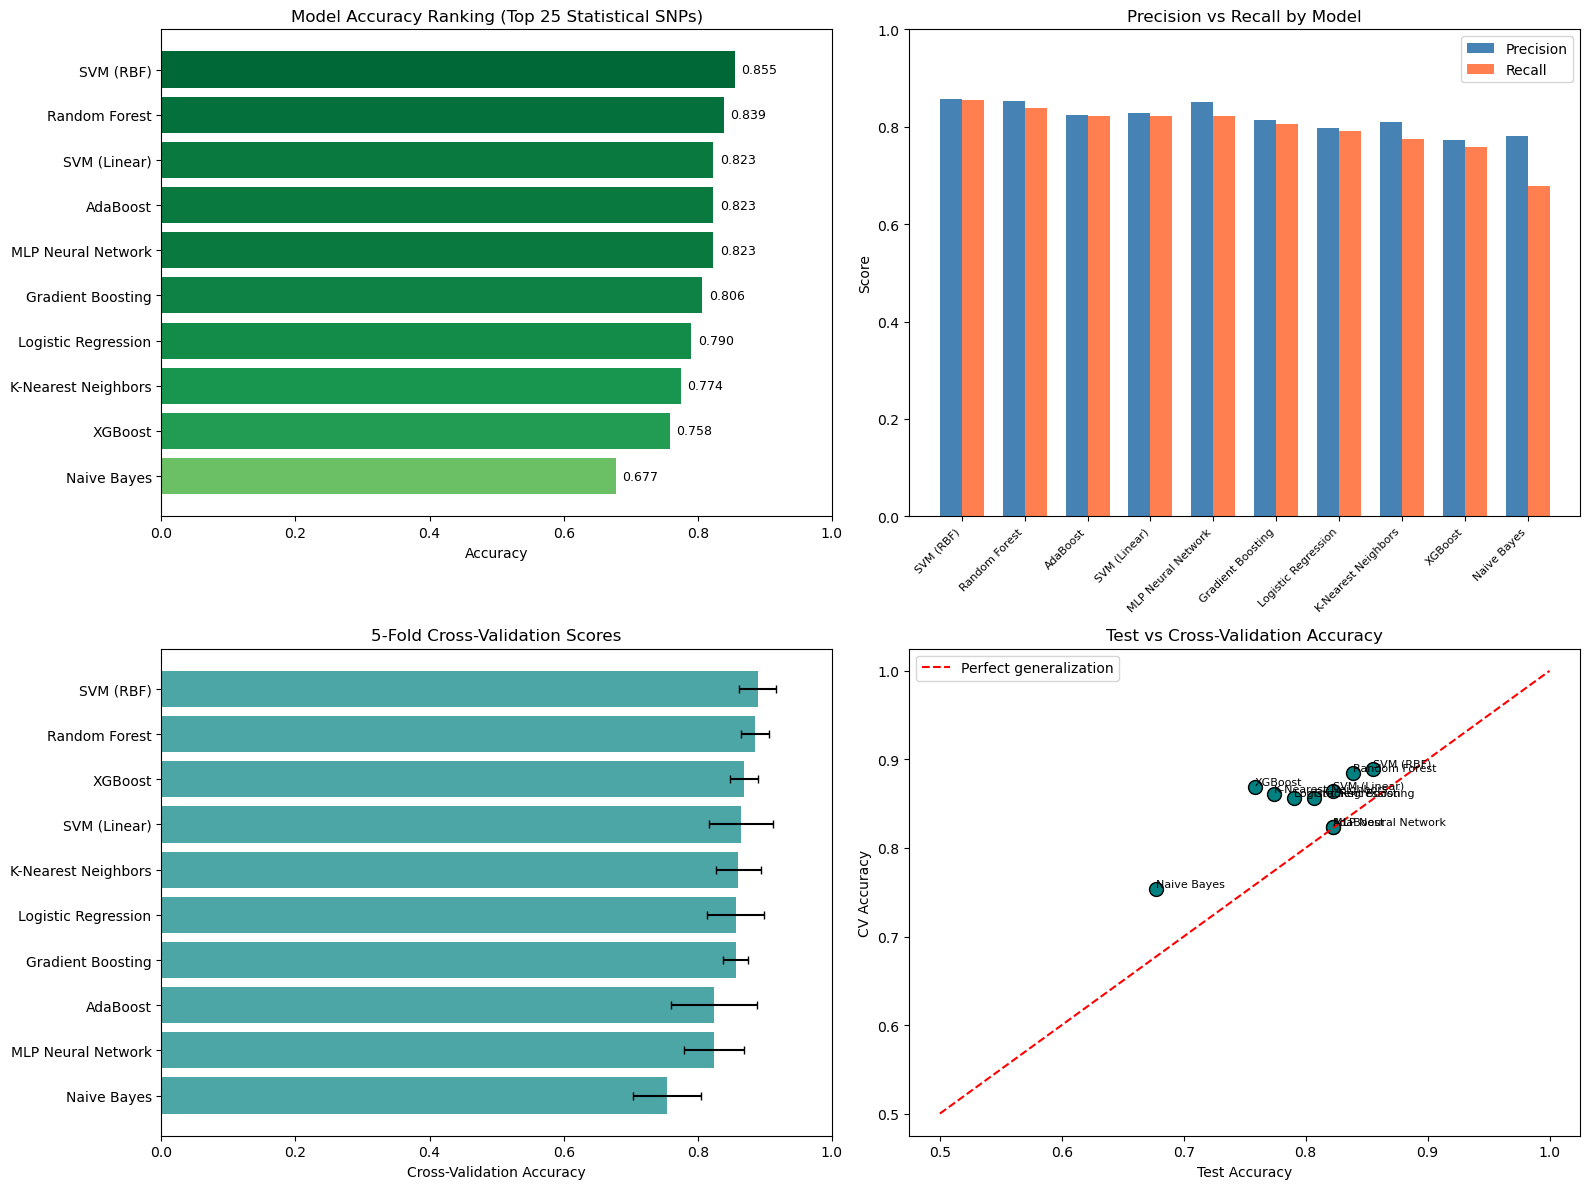

In [ ]:
# Model comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy ranking
ax = axes[0, 0]
sorted_results = results_df.sort_values('Accuracy', ascending=True)
colors = plt.cm.RdYlGn(sorted_results['Accuracy'].values / sorted_results['Accuracy'].max())
bars = ax.barh(sorted_results['Model'], sorted_results['Accuracy'], color=colors)
ax.set_xlabel('Accuracy')
ax.set_title('Model Accuracy Ranking (Top 25 Statistical SNPs)')
ax.set_xlim(0, 1)
for i, (acc, model) in enumerate(zip(sorted_results['Accuracy'], sorted_results['Model'])):
    ax.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=9)

# Plot 2: F1-Score comparison
ax = axes[0, 1]
x = np.arange(len(results_df))
width = 0.35
ax.bar(x - width/2, results_df['Precision'], width, label='Precision', color='steelblue')
ax.bar(x + width/2, results_df['Recall'], width, label='Recall', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Score')
ax.set_title('Precision vs Recall by Model')
ax.legend()
ax.set_ylim(0, 1)

# Plot 3: CV Score with error bars
ax = axes[1, 0]
sorted_cv = results_df.sort_values('CV Mean', ascending=True)
ax.barh(sorted_cv['Model'], sorted_cv['CV Mean'], xerr=sorted_cv['CV Std'],
        color='teal', alpha=0.7, capsize=3)
ax.set_xlabel('Cross-Validation Accuracy')
ax.set_title('5-Fold Cross-Validation Scores')
ax.set_xlim(0, 1)

# Plot 4: Accuracy vs CV (generalization check)
ax = axes[1, 1]
ax.scatter(results_df['Accuracy'], results_df['CV Mean'], s=100, c='teal', edgecolors='black')
for i, row in results_df.iterrows():
    ax.annotate(row['Model'], (row['Accuracy'], row['CV Mean']), 
                fontsize=8, ha='left', va='bottom')
ax.plot([0.5, 1], [0.5, 1], 'r--', label='Perfect generalization')
ax.set_xlabel('Test Accuracy')
ax.set_ylabel('CV Accuracy')
ax.set_title('Test vs Cross-Validation Accuracy')
ax.legend()

plt.tight_layout()
plt.show()

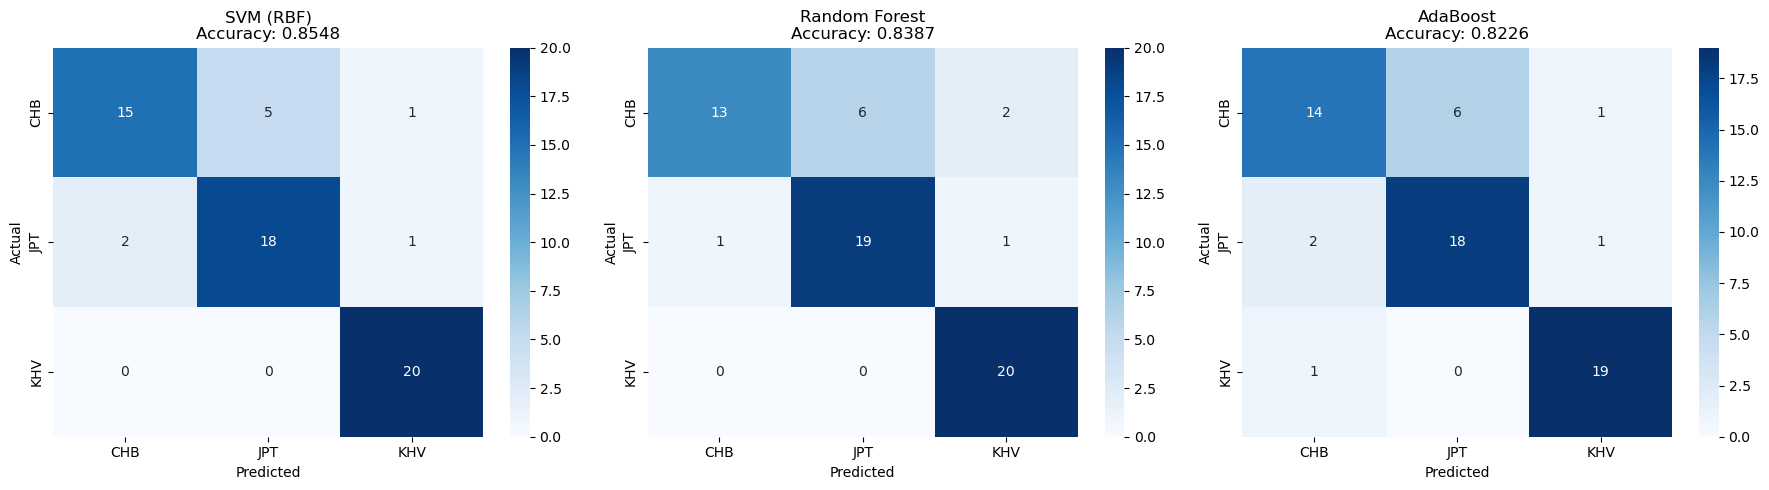

In [ ]:
# Confusion matrices for top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    clf = classifiers[model_name]
    
    # Get appropriate data
    if 'SVM' in model_name or 'Logistic' in model_name or 'KNN' in model_name or 'MLP' in model_name:
        X_te = X_test_25_scaled
    else:
        X_te = X_test_25.values
    
    if 'XGBoost' in model_name or 'MLP' in model_name:
        y_te = y_test_25_enc
        y_pred = clf.predict(X_te)
        y_te = le.inverse_transform(y_te)
        y_pred = le.inverse_transform(y_pred)
    else:
        y_te = y_test_25
        y_pred = clf.predict(X_te)
    
    cm = confusion_matrix(y_te, y_pred, labels=le.classes_)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    acc = accuracy_score(y_te, y_pred)
    ax.set_title(f'{model_name}\nAccuracy: {acc:.4f}')

plt.tight_layout()
plt.show()

## Step 6: Compare with FST-based Selection (if available)

In [ ]:
# Try to load FST-based top SNPs for comparison
try:
    fst_top_snps_path = str(PATHS.TOP_SNPS_FILE)
    fst_top_snps = pd.read_csv(fst_top_snps_path)['ID'].tolist()[:TOP_N]
    
    print(f"Loaded {len(fst_top_snps)} FST-selected SNPs")
    
    # Check overlap
    overlap = set(top_25_snps) & set(fst_top_snps)
    print(f"\nOverlap between methods:")
    print(f"  Statistical top {TOP_N}: {len(top_25_snps)} SNPs")
    print(f"  FST-based top {TOP_N}: {len(fst_top_snps)} SNPs")
    print(f"  Shared SNPs: {len(overlap)} ({100*len(overlap)/TOP_N:.1f}%)")
    
    if len(overlap) > 0:
        print(f"\nShared SNPs:")
        for snp in list(overlap)[:10]:
            print(f"  - {snp}")
        if len(overlap) > 10:
            print(f"  ... and {len(overlap) - 10} more")
            
except Exception as e:
    print(f"FST comparison not available: {e}")
    print("Run 03_fst_and_pca.ipynb first to generate FST-selected SNPs.")

FST comparison not available: 'ID'
Run 03_fst_and_pca.ipynb first to generate FST-selected SNPs.


## Step 7: Save Results

In [ ]:
# Save model comparison results
output_dir = PATHS.OUTPUT_DIR

# Save results table
results_path = str(output_dir / "statistical_ml_results.csv")
results_df.to_csv(results_path, index=False)
print(f"Model results saved to: {results_path}")

# Save top 25 SNPs with importance
top25_path = str(output_dir / "statistical_top25_snps.csv")
feature_importance.head(TOP_N).to_csv(top25_path, index=False)
print(f"Top 25 SNPs saved to: {top25_path}")

# Save top 25 SNP IDs for external use
top25_ids_path = str(output_dir / "statistical_top25_snp_ids.txt")
with open(top25_ids_path, 'w') as f:
    for snp in top_25_snps:
        f.write(f"{snp}\n")
print(f"Top 25 SNP IDs saved to: {top25_ids_path}")

# Save report
report_path = str(project_root / "reports" / "statistical_ml_report.txt")
with open(report_path, 'w') as f:
    f.write("="*70 + "\n")
    f.write("ML TRAINING ON STATISTICALLY-SELECTED SNPs\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Dataset:\n")
    f.write(f"  Samples: {len(df)}\n")
    f.write(f"  Populations: {list(y.unique())}\n")
    f.write(f"  Consensus SNPs: {len(available_consensus)}\n")
    f.write(f"  Top SNPs used: {TOP_N}\n\n")
    
    f.write(f"Model Results (Top 25 SNPs):\n")
    f.write("-"*70 + "\n")
    for _, row in results_df.iterrows():
        f.write(f"  {row['Model']:25} | Acc: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f} | CV: {row['CV Mean']:.4f}\n")
    
    f.write(f"\nBest Model: {results_df.iloc[0]['Model']}\n")
    f.write(f"  Accuracy: {results_df.iloc[0]['Accuracy']:.4f}\n")
    f.write(f"  F1-Score: {results_df.iloc[0]['F1-Score']:.4f}\n")

print(f"Report saved to: {report_path}")

Model results saved to: 1000genomes/output/statistical_ml_results.csv
Top 25 SNPs saved to: 1000genomes/output/statistical_top25_snps.csv
Top 25 SNP IDs saved to: 1000genomes/output/statistical_top25_snp_ids.txt
Report saved to: /home/Plutonium/Documents/BioinfoMidterm/reports/statistical_ml_report.txt


In [ ]:
# Final Summary
print("="*70)
print("STATISTICAL SNP ML TRAINING SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Samples: {len(df)}")
print(f"  Populations: {list(y.unique())}")

print(f"\nSNP Selection:")
print(f"  Consensus SNPs (from 03b): {len(available_consensus)}")
print(f"  Top SNPs for final training: {TOP_N}")

print(f"\nBest Performing Models:")
for i, row in results_df.head(3).iterrows():
    print(f"  {i+1}. {row['Model']}: {row['Accuracy']:.4f} accuracy")

print(f"\nTop 5 SNPs by Importance:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['snp']} (importance: {row['importance']:.4f}, MI: {row['mutual_information']:.4f})")

print(f"\nOutput Files:")
print(f"  - statistical_ml_results.csv")
print(f"  - statistical_top25_snps.csv")
print(f"  - statistical_top25_snp_ids.txt")
print(f"  - reports/statistical_ml_report.txt")

print(f"\nNext Steps:")
print(f"  - Compare with FST-based results (04_ml_training.ipynb)")
print(f"  - Use consensus SNPs from both methods for final model")
print(f"  - Apply to external validation datasets")

STATISTICAL SNP ML TRAINING SUMMARY

Dataset:
  Samples: 306
  Populations: ['KHV', 'CHB', 'JPT']

SNP Selection:
  Consensus SNPs (from 03b): 164
  Top SNPs for final training: 25

Best Performing Models:
  4. SVM (RBF): 0.8548 accuracy
  1. Random Forest: 0.8387 accuracy
  9. AdaBoost: 0.8226 accuracy

Top 5 SNPs by Importance:
  1. 3:100365528 (importance: 0.0336, MI: 0.2002)
  2. 11:61548559 (importance: 0.0260, MI: 0.1944)
  3. 17:40956277 (importance: 0.0258, MI: 0.1704)
  4. 18:18518431 (importance: 0.0164, MI: 0.1319)
  5. 4:101002868 (importance: 0.0161, MI: 0.1396)

Output Files:
  - statistical_ml_results.csv
  - statistical_top25_snps.csv
  - statistical_top25_snp_ids.txt
  - reports/statistical_ml_report.txt

Next Steps:
  - Compare with FST-based results (04_ml_training.ipynb)
  - Use consensus SNPs from both methods for final model
  - Apply to external validation datasets
